In [85]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
import numpy as np
from sklearn import metrics
from sklearn.metrics import make_scorer, r2_score, mean_squared_error

In [86]:
model=xgb.XGBRegressor()
#model=xgb.XGBRegressor(random_state=1,learning_rate=0.01,n_estimators=1000,max_depth=5,min_child_weight= 4,booster="dart")

In [87]:
data = pd.read_csv('data_important.csv')
data=data.fillna(0)
data = data.loc[data.SalePrice < 400000,].reset_index()

In [88]:
x = data.drop(columns='SalePrice')
y = data.SalePrice
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

In [95]:
model.fit(x_train, y_train)
print(model.score(x_train,y_train))
print(model.score(x_test,y_test))


0.9998594854183591
0.8564682117618932


In [96]:
prt = model.predict(x_train)
pr = model.predict(x_test)
res = y_test - pr
rest = y_train - prt

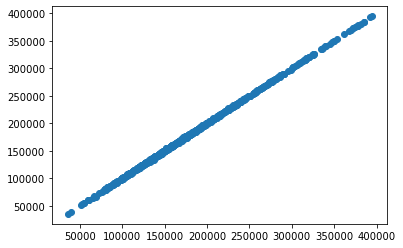

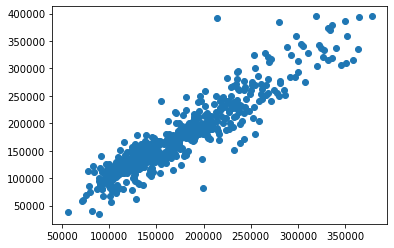

In [97]:
plt.scatter(prt,y_train)
plt.show()
plt.scatter(pr,y_test)
plt.show()

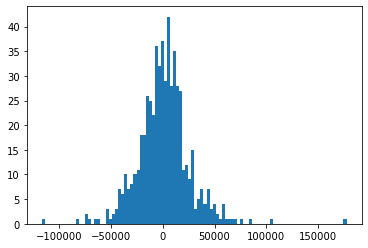

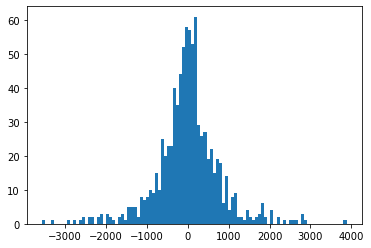

In [98]:
plt.hist(res,bins=100)
plt.show()
plt.hist(rest,bins=100)
plt.show()

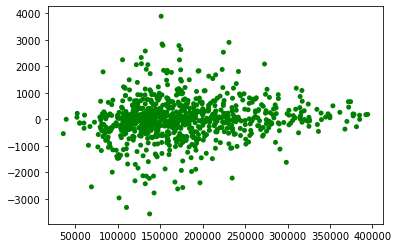

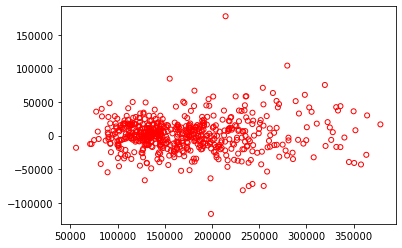

In [99]:
plt.scatter(prt,rest,s=25, edgecolors="none",facecolors='green')
plt.show()
plt.scatter(pr,res,s=25, edgecolors="red",facecolors='none')

plt.show()

In [100]:
# ROUND 1:
param_grid1 = {
    'max_depth':np.arange(1,11,2),
    'min_child_weight':np.arange(1,11,2),
 'n_estimators':[10,100,200]   
}

# maxdepth [1,3,5,7,9]
# minchil [1,3,5,7,9]
# n_est [10,100,500,1000]
# t1: 1,1,10, t2: 3,1,10, t3 5,1,10

# First Search
gsearch1 = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror'),
    param_grid1,
    cv=4)

gsearch1 = gsearch1.fit(x_train, y_train)

In [101]:
best_params = gsearch1.best_params_
best_params1 = gsearch1.best_params_
best_params, gsearch1.best_score_

({'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 200},
 0.8608985734838416)

In [102]:
# ROUND 2:
param_grid2 = {
    'max_depth':[1,2,3],
    'min_child_weight':[1,2,3],
 'n_estimators':[150,200,50]   
}

# First Search
gsearch2 = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror'),
    param_grid2,
    cv=4)

gsearch2 = gsearch2.fit(x_train, y_train)

In [103]:
best_params = gsearch2.best_params_
best_params2 = gsearch2.best_params_
best_params, gsearch2.best_score_

({'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 200},
 0.8608985734838416)

In [104]:
param_grid3 = {'gamma':[float(i)/10.0 for i in range(0,6)]}

gsearch3 = GridSearchCV(
    xgb.XGBRegressor(**best_params,objective='reg:squarederror'),
    param_grid3,
    cv=5
)

gsearch3 = gsearch3.fit(x_train, y_train)

In [105]:
best_params.update(gsearch3.best_params_)
best_params3 = gsearch3.best_params_
best_params, gsearch3.best_score_

({'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 200, 'gamma': 0.0},
 0.8497736304877506)

In [106]:
param_grid4 = {
    'colsample_bytree':[float(i)/10.0 for i in range(1,11)],
    'subsample':[float(i)/10.0 for i in range(1,11)]
}

gsearch4 = GridSearchCV(
    xgb.XGBRegressor(**best_params2,objective='reg:squarederror'),
    param_grid4,
    cv=3   
)

gsearch4 = gsearch4.fit(x_train, y_train)

In [107]:
prev_best  = best_params2
best_params2.update(gsearch4.best_params_)
best_params2, gsearch4.best_score_

({'max_depth': 1,
  'min_child_weight': 1,
  'n_estimators': 200,
  'gamma': 0.0,
  'colsample_bytree': 0.4,
  'subsample': 0.9},
 0.8528933197047174)

In [111]:
best_params

{'max_depth': 1,
 'min_child_weight': 1,
 'n_estimators': 200,
 'gamma': 0.0,
 'colsample_bytree': 0.4,
 'subsample': 0.9}

In [119]:
# Compare base model with tuned model: 
base_booster = xgb.XGBRegressor()
base_booster_2 = xgb.XGBRegressor(n_estimators=200,max_depth=1,min_child_weight= 1)
tune_booster = xgb.XGBRegressor(**best_params,objective='reg:squarederror')

# We want to shuffle the data for the cross_val_score 
kf = KFold(5, shuffle=True, random_state=1)

In [120]:
score1 = cross_val_score(
    base_booster, 
    x_train, 
    y_train,
    cv = kf
)

score2 = cross_val_score(
    tune_booster, 
    x_train, 
    y_train, 
    cv = kf
)
score3 = cross_val_score(
    base_booster_2, 
    x_train, 
    y_train,
    cv = kf
)


In [124]:
print(f"Base: R-square: {score1.mean()} (+/-{score1.std()*2})")
print(f"Tuned: R-square: {score2.mean()} (+/-{score2.std()*2})")   
print(f"Tuned: R-square: {score3.mean()} (+/-{score3.std()*2})")   
print(score1)
print(score2)
print(score3)

Base: R-square: 0.8154157939291709 (+/-0.08298429093219507)
Tuned: R-square: 0.8469632751414427 (+/-0.06552178047294435)
Tuned: R-square: 0.8377245902722426 (+/-0.08462745467096439)
[0.84678997 0.8749654  0.81201398 0.76079487 0.78251475]
[0.87349264 0.89698781 0.82940905 0.80999729 0.82492958]
[0.8777335  0.88943563 0.81925893 0.77234473 0.82985017]


In [125]:
# Compare CV scores with final score on unseen data:
tune_booster.fit(x_train, y_train)
pred = tune_booster.predict(x)
metrics.mean_squared_log_error(y, pred)
res = y - pred 

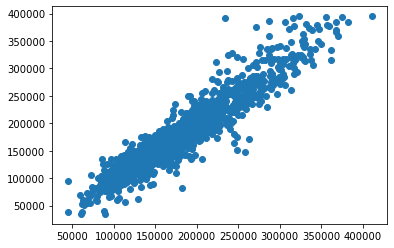

In [126]:
plt.scatter(pred,y)
plt.show()

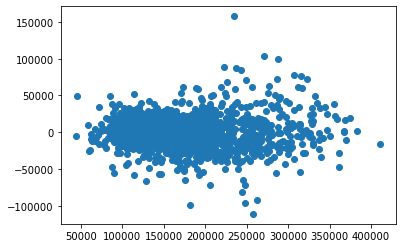

In [127]:
plt.scatter(pred,res)
plt.show()

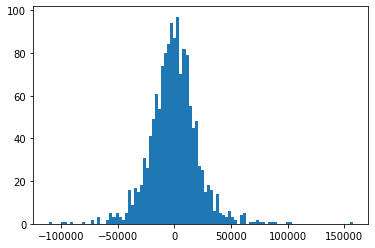

In [128]:
plt.hist(res,bins=100)
plt.show()